### The Dataset
Contains music compiled by Altai between 2015 and 2018

Split up into 5 second intervals, with 3000 training data, and 1000 testing data for each of the three genres, which being

In [6]:
genres = {
    0: 'metal',
    1: 'jazz',
    2: 'pop'
}

The data will be doubled using random augmentations

Audio data is encoded by taking a sample of the pressure at certain numbers throughout the audio, with the typical CD quality being 44.1 kHz

Useful python libraries:
* librosa can help extract the useful traits from the data
* IPython.display.Audio allows playing audio from python

### Loading the Audio

In [46]:
import librosa
audio_data = './songs/train/0/0050.mp3'
x, sr = librosa.load(audio_data)

/home/serialguitarist/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [47]:
print(x)
print(sr)

[-6.9555930e-11  6.8792361e-11 -5.5110271e-11 ...  1.1819429e-01
  2.0977035e-01  0.0000000e+00]
22050


In [48]:
x.shape

(109752,)

In [49]:
import IPython.display as ipd
ipd.Audio(x, rate = sr)

### Visualizing the Audio

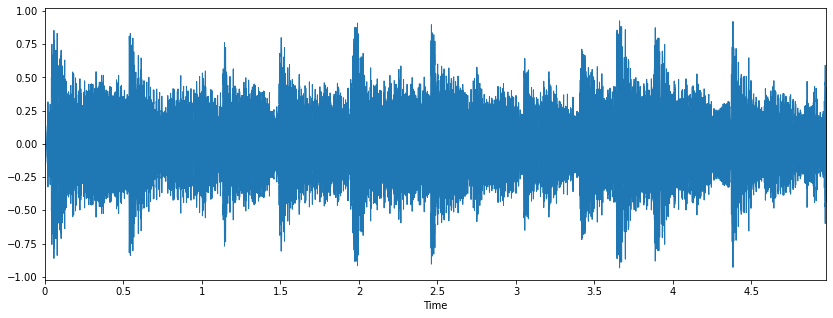

In [32]:
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize = (14, 5))

librosa.display.waveplot(x , sr = sr)

### Spectrogram
A visual way of representing the signal strength, or "loudness" of the a signal over time at various frequences present in a particular waveform

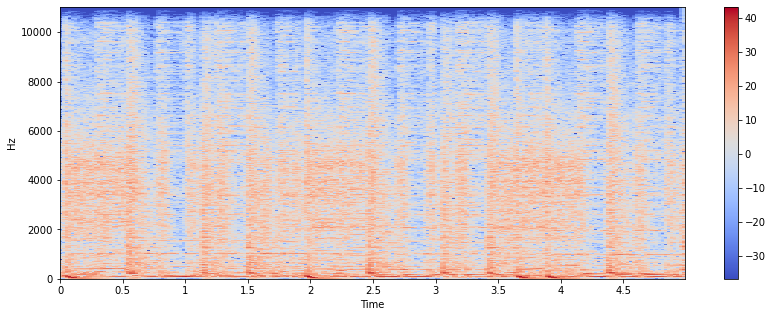

In [36]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))

plt.figure(figsize = (14, 5))
# linear spectrogram
librosa.display.specshow(Xdb, sr = sr, x_axis = 'time', y_axis = 'hz')
plt.colorbar()

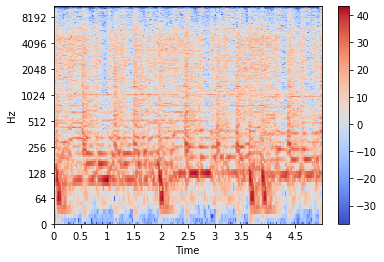

In [37]:
# logarithmic spectrogram
librosa.display.specshow(Xdb, sr = sr, x_axis = 'time', y_axis = 'log')
plt.colorbar()

### Creating an audio signal
The following is creating a 440 Hz pure sine audio

In [45]:
import numpy as np
import soundfile as sf
sr = 22050 # sample rate
T = 5.0    # seconds
t = np.linspace(0, T, int(T*sr), endpoint=False) # time variable
x = 0.5*np.sin(2*np.pi*440*t)# pure sine wave at 440 Hz
#Playing the audio
ipd.Audio(x, rate=sr) # load a NumPy array
#Saving the audio
sf.write('tone_220.wav', x, sr, 'PCM_24')

### Feature extraction from audio signal
The spectral features, or the frequency based features are obtaine by converting the time based signal into the fequency domain using Fourier transform
#### Spectral Centroid
Which frequency of the energy of a spectrum is centered upon. ie the center of mass

In [55]:
import sklearn
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape

(215,)

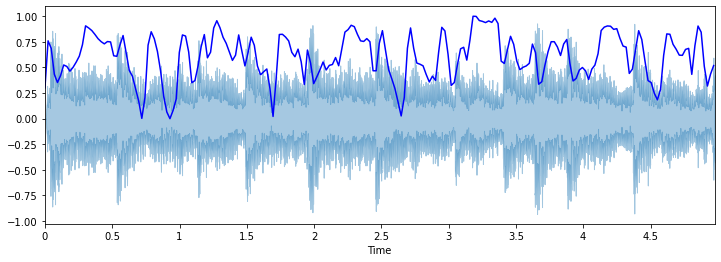

In [56]:
# Computing the time variable for visualization
plt.figure(figsize=(12, 4))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='b')

#### Spectral Rolloff
Measure of the shape of the signal

The frequency at which high frequencies decline to 0

The fracion of bins in the power spectrum where 85% of its power is at lower frequencies

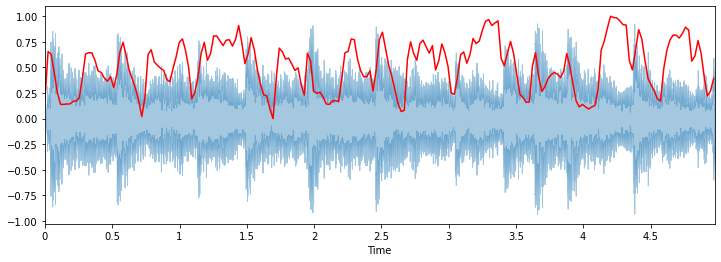

In [58]:
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]
plt.figure(figsize=(12, 4))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

#### Spectral Bandwitch
The width of the band of light at one half of the peak maximum

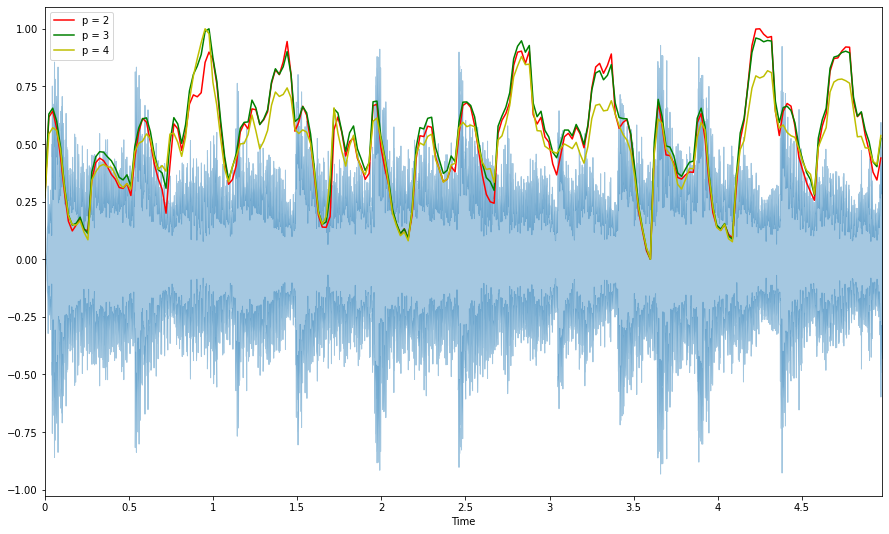

In [60]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=4)[0]
plt.figure(figsize=(15, 9))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))

#### Zero Crossing Rate
Measure of smoothness of a signal

Used to calculate the number of zero-crosing within a segment of that signal

A voice generally oscillates slowely, and generally higher in percussive sounds like in metal and rock

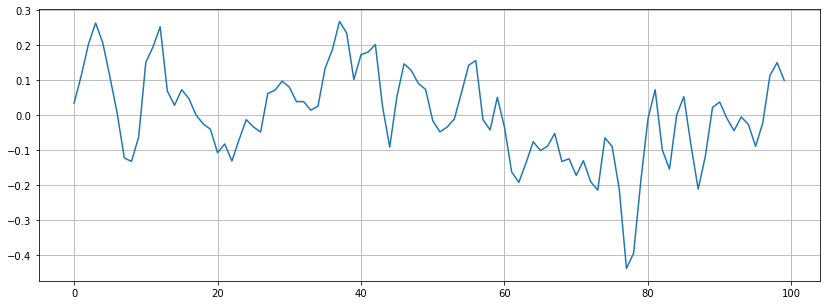

In [61]:
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

Crosses zero 18 times here

In [64]:
zero_crossings = librosa.zero_crossings(x[n0:n1], pad = False)
print(sum(zero_crossings))

18


#### Mel-Frequency Cepstral Coefficients (MFCCs)
A small set of features, of about 10-20, concisely desribing the overall shape of a spectral envelope

In [66]:
mfccs = librosa.feature.mfcc(x, sr = sr)
print(mfccs.shape)

(20, 215)


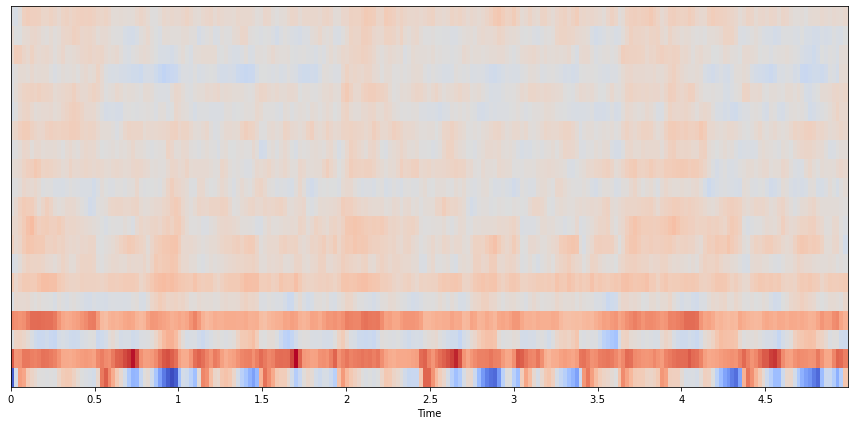

In [67]:
#Displaying  the MFCCs:
plt.figure(figsize=(15, 7))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

#### Chroma Feature
How much energy of each pitch class (C, C#, D, ..., B) is present in the signal

Provides a robust way to describe a similarity measure between music pieces

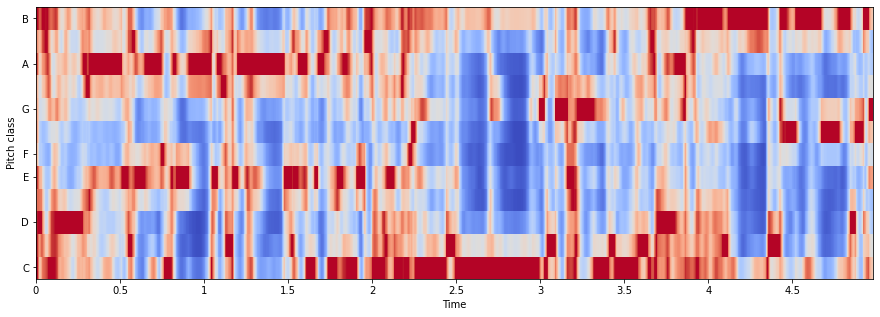

In [77]:
chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=100)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=100, cmap='coolwarm')

## Training on the data

### Relevant libraries

In [85]:
import pandas as pd
import numpy as np
from numpy import argmax
import matplotlib.pyplot as plt

import librosa
import librosa.display
import IPython.display
import random
import warnings
import os
from PIL import Image
import pathlib
import csv

import sys

import warnings

warnings.simplefilter('ignore')

In [86]:
genres = 'metal jazz pop'.split()
genres

['metal', 'jazz', 'pop']

The following will convert all the audio files into the spectrograms

(109752,)
(109752,)
(110250,)
(109752,)
(109752,)
(109752,)
(109752,)
(109752,)
(110250,)
(110250,)
(110250,)
(109752,)
(109752,)
(109752,)
(110250,)
(109752,)
(109752,)
(109752,)
(110250,)
(109752,)
(109752,)
(109752,)
(109752,)
(109752,)
(110250,)
(110250,)
(110250,)
(109752,)
(109752,)
(110250,)
(110250,)
(109752,)
(110250,)
(109752,)
(109752,)
(109752,)
(109752,)
(109752,)
(109752,)
(110250,)
(110250,)
(109752,)
(109752,)
(109752,)
(110250,)
(110250,)
(110250,)
(110250,)
(109752,)
(109752,)
(109752,)
(109752,)
(109752,)
(109752,)
(109752,)
(110250,)
(109752,)
(110250,)
(109752,)
(110250,)
(109752,)
(109752,)
(109752,)
(110250,)
(109752,)
(110250,)
(109752,)
(110250,)
(109752,)
(109752,)
(110250,)
(110250,)
(109752,)
(110250,)
(109752,)
(109752,)
(109752,)
(109752,)
(109752,)
(110250,)
(110250,)
(109752,)
(110250,)
(109752,)
(109752,)
(110250,)
(109752,)
(110250,)
(109752,)
(109752,)
(109752,)
(110250,)
(110250,)
(109752,)
(110250,)
(109752,)
(110250,)
(110250,)
(109752,)
(109752,)


KeyboardInterrupt: 

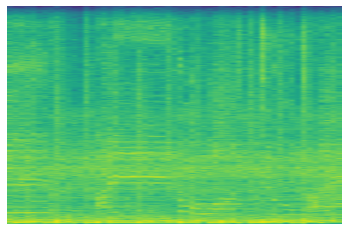

In [92]:
for i, g in enumerate(genres):
    pathlib.Path(f'./spectrograms/training/{i}').mkdir(parents = True, exist_ok = True)
    for filename in os.listdir(f'./songs/train/{i}'):
        songname = f'./songs/train/{i}/{filename}'
        y, sr = librosa.load(songname, mono = True, duration = 5)
        print(y.shape)
        plt.specgram(y, 
                     NFFT = 2048, 
                     Fs = 2, 
                     Fc = 0, 
                     noverlap = 128, 
                     #cmap = 'cmap',
                     sides = 'default',
                     mode = 'default',
                     scale = 'dB')
        plt.axis('off')
        plt.savefig(f'./spectrograms/training/{i}/{filename[:-3]}png')